In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df = pd.read_csv('/kaggle/input/cheapest-electric-cars/Cheapestelectriccars-EVDatabase.csv')
df.head()

After reading the files, we could see there's 11 columns. We could explain those columns by looking at the units. 
- Name : The EV's name
- Subtitle : Description of the vehicle, also the capacity
- Acceleration : Vehicle's Acceleration
- Top speed (km/h) : Vehicle's top speed
- Range (km): Vehicle's maximum range if battery is full
- Efficiency (Wh/km) : Vehicle's battery consumption per kilometre
- FastChargeSpeed (km/h) : Vehicle charging time, how many km per hour of charging
- Drive : Vehicle drive, RWD/FWD/AWD
- NumberOfSeats : Vehicle capacity
- PriceinGermany : Vehicle's price in Euro
- PriceinUK : Vehicle's price in Poundsterling

Almost all columns are in object type because of the units. It should be removed and make it to int to make it easier to do EDA.

In [ ]:
df['Acceleration'] = df.Acceleration.str.strip(' sec')
df['TopSpeed'] = df.TopSpeed.str.strip(' km/h')
df['Range'] = df.TopSpeed.str.strip(' km')
df['Efficiency'] = df.Efficiency.str.strip(' Wh/km')
df['FastChargeSpeed'] = df.FastChargeSpeed.str.strip(' km/h')
df['PriceinGermany'] = df.PriceinGermany.str.strip('€')
df['PriceinUK'] = df.PriceinUK.str.strip('£')
df['PriceinGermany'] = df.PriceinGermany.str.replace(',','')
df['PriceinUK'] = df.PriceinUK.str.replace(',','')

In [ ]:
df.head()

We could see that theres missing values in FastChargeSpeed notated as '-'. Let's see how many of it and how to deal with it

In [ ]:
df[df.FastChargeSpeed.str.contains('-')]['FastChargeSpeed']

There's only 5 of them. We could remove it

In [ ]:
df.FastChargeSpeed.replace('-', np.nan, inplace=True)
df.dropna(subset=['FastChargeSpeed'], axis = 0, inplace=True)

Now let's see another columns with missing values

In [ ]:
df.isna().sum()

We should drop the rows that have both PriceinGermany and PriceinUK missing.

In [ ]:
df.dropna(subset=['PriceinGermany','PriceinUK'],how = 'all', inplace=True)

If we drop all the missing rows of PriceinGermany and PriceinUK, it'll be too much rows to drop. So, we can fill the missing values in PriceinGermany with PriceinUK * 0.86 and PriceinUK with PriceinGermany * 1.17.

**at the time i'm doing eda on this dataset, euro to pound sterling was 0.86 and pound sterling to euro was 1.17*

In [ ]:
currency = ['PriceinGermany','PriceinUK']
for cols in currency:
    df[cols] = df[cols].astype('float')
    
df['PriceinGermany'].fillna(df['PriceinUK'] * 0.86, axis=0, inplace=True)
df['PriceinUK'].fillna(df['PriceinGermany'] * 1.17, axis=0, inplace=True)
df['MeanPrice'] = (df.PriceinGermany + df.PriceinUK) / 2

We could change all the data types, because most of them previously were object.

I add another columns MeanPrice because it'll be easier if it only had 1 price columns.

In [ ]:
cats = ['NumberofSeats','Drive']
nums = ['Acceleration','TopSpeed','Range','Efficiency','FastChargeSpeed']

for cols in cats:
    df[cols] = df[cols].astype('category')

for cols in nums :
    df[cols] = df[cols].astype('float')

In [ ]:
df['Manufacture'] = df.Name.str.split(' ', 1, expand=True)[0]

df = df.reindex(columns=['Name',
'Manufacture',
'Subtitle',
'Acceleration',
'TopSpeed',
 'Range',
 'Efficiency',
 'FastChargeSpeed',
 'Drive',
 'NumberofSeats',
 'PriceinGermany',
 'PriceinUK',
 'MeanPrice'])

I add Manufacture columns from the first word of Name column.

In [ ]:
df.head()

After we did all the cleaning, now we proceed to do analysis on the cleaned dataset.

In [ ]:
prices = ['PriceinGermany','PriceinUK','MeanPrice']
for price in prices :
    sns.displot(df[price])

In [ ]:
for skew in prices:
    print(df[skew].skew())

The price columns showed distribution with positive skewness.

In [ ]:
sns.countplot(x = 'Drive', data = df)

We could see that the EV's wheel drive is dominated by FWD followed by AWD. There's many things causing this, but one of it are FWD is cheaper to design and make than other drives, which means the vehicle may be less expensive for consumers, and also have better mileage.

Let's see the distribution between Efficiency and the price

In [ ]:
sns.relplot(x = 'MeanPrice', y = 'Efficiency', hue='Drive', data = df)

We could see that majority of FWD EV's are cheaper and more efficient.

The downside of an FWD vehicle is that the handling suffers somewhat. While traction is good, handling the vehicle around corners and curves isn’t as strong as an RWD car, especially at faster speeds.

Lets see which manufacture produce most EV

In [ ]:
sns.countplot(x = 'Manufacture', data=df, order=df.Manufacture.value_counts().index)
plt.xticks(rotation = 90)
plt.show()

Majority of EV's are produced by Audi and followed by Tesla.

In [ ]:
sns.countplot(x = 'NumberofSeats', hue='Drive', data=df)

The market for EV's is targeted for family use for now. As we could see, the number of seats are dominated by 5 seats followed by 7. Some of the benefits of more seats are storage space, variety, towing capacity, etc.

Let's see the correlation between variables

In [ ]:
sns.heatmap(df.corr(), annot=True)

As we could see, the car prices mostly affected by TopSpeed, Range, and FastChargeSpeed.

In [ ]:
high_corr = ['TopSpeed','Range','FastChargeSpeed']
for cols in high_corr:
    sns.relplot(x = 'MeanPrice',y = cols, data = df, hue = 'Drive')

Based on the analytics, there's somethings that affecting the EV's price, and we could not merely choose the best EV's just by seeing the price alone.

In [ ]:
df.sort_values(by = ['MeanPrice','Efficiency'], ascending = True).head()

And the cheapest EV based on the datasets is Fiat 500e Hatchback 24 kWh.


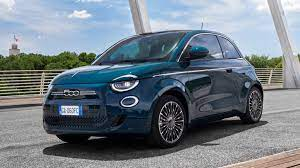

Citations : 
- https://www.usautosales.info/blog/front-wheel-drive-vs-rear-wheel-drive/
- https://www.honda.com.au/en/news/2019/seven-benefits-of-a-seven-seater